In [1]:
from functools import reduce
from itertools import islice
import math
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def shuffle(*dfs):
  dataset = reduce(lambda a,b: np.append(a, b, axis=0), dfs)
  permutation = np.random.permutation(dataset.shape[0])
  shuffled = dataset[permutation]
  return shuffled


unit = 0.15

on = unit * 0.1
off = unit * 0.00


def generate_cluster(unit, cross_cov, mu, count):
    mu = np.array(mu)
    sigma_1, sigma_2, sigma_3 = unit, unit, unit
    sigma_1_2, sigma_1_3, sigma_2_3 = cross_cov
    cov = np.array([
      [sigma_1, sigma_1_2, sigma_1_3],
      [sigma_1_2, sigma_2, sigma_2_3],
      [sigma_1_3, sigma_2_3, sigma_3]
    ])
    ds = np.random.multivariate_normal(mu, cov, count)
    return ds


def reduce_correlation(ds, noise):
    count = ds.shape[0]
    ds_t = ds.T
    for i, x in enumerate(noise):
        num = int(count*x)
        ds_t[i].put(np.random.choice(count, num, replace=False), np.random.choice(ds.T[i], num))
    return ds_t.T


rv1 = generate_cluster(unit, (on, -off, off), [2,0,0], 250000) 
rv2 = generate_cluster(unit, (on, off, -off), [0,0,2], 500000)
rv3 = generate_cluster(unit, (-on, off, off), [0,2,0], 500000)
rv4 = generate_cluster(unit, (-on, -off, -off), [-1,-1,-1], 1000000)

# rv5 = generate_cluster(unit, (on, -off, off), [0,0,2], 1250000)
# rv6 = generate_cluster(unit, (-on, off, -off), [0,2,0], 1000000)
# 
# data = np.append(shuffle(rv1, rv2, rv3, rv4), shuffle(rv5, rv6), axis=1)

data = reduce(lambda a,b: np.append(a, b, axis=0), [rv1, rv2, rv3, rv4])

# ind_var = np.random.uniform(-1, 1, [data.shape[0], 20])

# data = np.append(data, ind_var, axis=1)

data = shuffle(data)

# data = reduce_correlation(data, [0.75, 0.75, 0.75])

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-2.82166014, -2.69167798, -2.56169582, -2.43171366, -2.3017315 ,
        -2.17174934, -2.04176718, -1.91178502, -1.78180286, -1.6518207 ,
        -1.52183854, -1.39185638, -1.26187422, -1.13189206, -1.0019099 ,
        -0.87192774, -0.74194558, -0.61196342, -0.48198127, -0.35199911,
        -0.22201695, -0.09203479,  0.03794737,  0.16792953,  0.29791169,
         0.42789385,  0.55787601,  0.68785817,  0.81784033,  0.94782249,
         1.07780465,  1.20778681,  1.33776897,  1.46775113,  1.59773329,
         1.72771545,  1.85769761,  1.98767977,  2.11766193,  2.24764409,
         2.37762625,  2.50760841,  2.63759057,  2.76757272,  2.89755488,
         3.02753704,  3.1575192 ,  3.28750136,  3.4174835

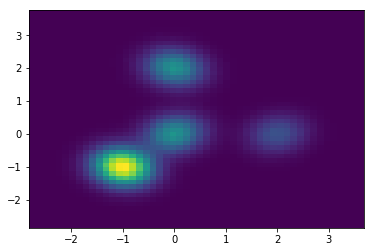

In [3]:
plt.hist2d(data[:,0], data[:,1], bins=50)

In [127]:
class VectorQuantizationVAE(object):
    
    def __init__(self, n_input_units, n_hidden_layers, n_hidden_units, n_latent_units, 
                 learning_rate=0.005, batch_size=100, min_beta=1.0, max_beta=1.0):
        self.n_input_units = n_input_units
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_units = n_hidden_units
        self.n_latent_units = n_latent_units
        self.learning_rate = learning_rate
        self.batch_size = int(batch_size)
        self.min_beta = min_beta
        self.max_beta = max_beta
    
            
    class Encoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_latent_units):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_latent_units = n_latent_units
            
        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []
            
        def add_hidden_layer(self, inputs):
            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]
            
        def add_embeds(self, inputs):
            self.embeds = tf.Variable(tf.random_normal([self.n_latent_units, self.n_hidden_units], stddev=0.2))
            self.z_e = inputs
            self.expanded_z_e = tf.expand_dims(self.z_e, axis=-2)
            norm = tf.norm(self.expanded_z_e - self.embeds, axis=-1)
            self.k = tf.argmin(norm, axis=-1)
            self.z_q = tf.gather(self.embeds, self.k)
            
            # self.expanded_embeds = tf.expand_dims(self.embeds, axis=-2)
            # i = tf.argmin(tf.norm(self.expanded_embeds - self.z_e, axis=-1), axis=-1)
            # self.z_i = tf.gather(self.z_e, i)
                        
        def build(self, inputs):
            self.init_hidden_layers()
            
            layer = self.add_hidden_layer(inputs)
            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)
                            
            self.add_embeds(layer)
        
        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers                    
            ]
            
            embeds, = sess.run([self.embeds])
                        
            return layers, embeds
            
            
    class Decoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_output_units):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_output_units = n_output_units
            
        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []
            
        def add_hidden_layer(self, inputs):
            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]
        
        def add_output(self, inputs):
            self.output_layer = tf.layers.Dense(units=self.n_output_units)
            self.output = self.output_layer.apply(inputs)
            return self.output
            
        def build(self, inputs):
            self.init_hidden_layers()
            
            layer = self.add_hidden_layer(inputs)
            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)
                
            self.add_output(layer)
        
        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers
            ]
            
            output = sess.run([self.output_layer.kernel, self.output_layer.bias])
            
            return layers, output
    
    def build_losses(self, x, encoder, decoder):
        output = decoder.output
        z_e, z_q = encoder.z_e, encoder.z_q
        feature_loss = tf.reduce_sum(tf.squared_difference(x, output), axis=1)
        latent_loss = self.beta * tf.reduce_sum(tf.squared_difference(z_e, tf.stop_gradient(z_q)), axis=1)
        quantized_loss = tf.reduce_sum(tf.squared_difference(tf.stop_gradient(z_e), z_q), axis=1)
        # attract = self.gamma * tf.reduce_mean(tf.squared_difference(tf.stop_gradient(z_i), embeds))
        # repel = self.gamma * tf.reduce_mean(tf.squared_difference(tf.expand_dims(embeds, axis=-2), embeds))
        
        loss = tf.reduce_mean(feature_loss + latent_loss + quantized_loss)
        return loss, feature_loss, latent_loss, quantized_loss
      
    def initialize_tensors(self):
        self.x = tf.placeholder("float32", [self.batch_size, self.n_input_units])
        self.beta = tf.placeholder("float32", [1, 1])
        self.gamma = tf.placeholder("float32", [1, 1])
        self.encoder = self.Encoder(self.n_hidden_layers, self.n_hidden_units, self.n_latent_units)
        self.encoder.build(self.x)
        self.decoder = self.Decoder(self.n_hidden_layers, self.n_hidden_units, self.n_input_units)
        self.decoder.build(self.encoder.z_q)
        self.loss, self.feature_loss, self.latent_loss, self.quantized_loss = self.build_losses(self.x, self.encoder, self.decoder)
        
    def generate_beta_values(self, data_count, epochs):
        num_batches = int(data_count / self.batch_size)
        total_steps = (num_batches * epochs) - epochs
        beta_delta = self.max_beta - self.min_beta
        log_beta_step = 5 / float(total_steps)
        beta_values = [
            self.min_beta + (beta_delta * (1 - math.exp(-5 + (i * log_beta_step))))
            for i in range(total_steps)
        ]
        return beta_values
    
    def generate_gamma_values(self, data_count, epochs):
        num_batches = int(data_count / self.batch_size)
        total_steps = (num_batches * epochs) - epochs
        log_beta_step = 5 / float(total_steps)
        gamma_values = [math.exp(-i * log_beta_step) for i in range(total_steps)]
        return gamma_values
        
    def train_from_rdd(self, data_rdd, epochs=1):
        self.initialize_tensors()
        
        data_count = data_rdd.count()
        beta_values = self.generate_beta_values(data_count, epochs)
        gamma_values = self.generate_gamma_values(data_count, epochs)
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch_index in range(epochs): 
                iterator = data_rdd.toLocalIterator()
                batch_index = 0
                while True:
                    batch = np.array(list(islice(iterator, self.batch_size)))
                    if batch.shape[0] == self.batch_size:
                        beta = beta_values.pop(0) if len(beta_values) > 0 else self.min_beta
                        gamma = gamma_values.pop(0) if len(gamma_values) > 0 else 0
                        feed_dict = {self.x: np.array(batch), self.beta: np.array([[beta]]), self.gamma: np.array([[gamma]])}
                        
                        if not batch_index % 100:
                            print("beta: {}".format(beta))
                            ls, f_ls, d_ls, q_ls = sess.run([self.loss, self.feature_loss, self.latent_loss, self.quantized_loss], feed_dict=feed_dict)
                            print("loss={}, avg_feature_loss={}, avg_latent_loss={}, avg_quantized_loss={}".format(ls, np.mean(f_ls), np.mean(d_ls), np.mean(q_ls)))
                            print('running batch {} in epoch {}'.format(batch_index, epoch_index))
                            k, = sess.run([self.encoder.k], feed_dict=feed_dict)
                            print("k={}".format(k))
                        sess.run(optimizer, feed_dict=feed_dict)
                        batch_index += 1
                    else:
                        print("incomplete batch: {}".format(batch.shape))
                        break
                
            print("evaluating model...")
            encoder_layers, embeds = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)
            
        return VectorQuantizationVAEModel(encoder_layers, embeds, decoder_layers, eval_output)
             
    def train(self, data, visualize=False, epochs=1):
        self.initialize_tensors()
        
        data_size = data.shape[0]
        batch_size = self.batch_size
        beta_values = trainer.generate_beta_values(data_size, epochs)
        gamma_values = self.generate_gamma_values(data_size, epochs)
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch_index in range(epochs):
                batch_index = 0
                while (batch_index * batch_size) < data_size:
                    batch = data[batch_index * batch_size:(batch_index+1) * batch_size]
                    beta = beta_values.pop(0) if len(beta_values) > 0 else self.min_beta
                    gamma = gamma_values.pop(0) if len(gamma_values) > 0 else 0
                    feed_dict = {self.x: batch, self.beta: np.array([[beta]]), self.gamma: np.array([[gamma]])}
                    sess.run(optimizer, feed_dict=feed_dict)
                
                    if visualize and (not batch_index % int((data_size/batch_size)/4) or batch_index == int(data_size/batch_size) - 1):
                        d, ls, f_ls, d_ls, q_ls = sess.run([
                            self.decoder.output, self.loss, self.feature_loss, self.latent_loss, self.quantized_loss
                        ], feed_dict=feed_dict)
                        plt.scatter(batch[:,0], batch[:,1])
                        plt.show()
                        plt.scatter(d[:,0], d[:,1])
                        plt.show()
                        print("beta: {}".format(beta))
                        print("gamma: {}".format(gamma))
                        print("loss={}, avg_feature_loss={}, avg_latent_loss={}, avg_quantized_loss={}".format(ls, np.mean(f_ls), np.mean(d_ls), np.mean(q_ls)))
                        print('running batch {} in epoch {}'.format(batch_index, epoch_index))
                        k, = sess.run([self.encoder.k], feed_dict=feed_dict)
                        print("k={}".format(k))
                        embeds, = sess.run([self.encoder.embeds], feed_dict=feed_dict)
                        print("embeds={}".format(embeds))
            
                    batch_index += 1
                
            encoder_layers, embeds = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)
            
        return VectorQuantizationVAEModel(encoder_layers, embeds, decoder_layers, eval_output)
            
        
class VectorQuantizationVAEModel(object):
    def __init__(self, encoder_layers, embeds, decoder_layers, output):
        self.encoder = self.EncoderModel(encoder_layers, embeds)
        self.decoder = self.DecoderModel(decoder_layers, output)
        
    def save(self, path):
        encoder_layers, embeds = self.encoder.dump()
        decoder_layers, decoder_output = self.decoder.dump()
        serializable_model = (encoder_layers, embeds, decoder_layers, decoder_output)
        pickle.dump(serializable_model, open(path, 'w+'))
        
    def encode(self, x):
        return self.encoder.encode(x)
    
    def project(self, x):
        return self.encoder.encode(x)[0]
      
    def decode(self, x):
       return self.decoder.decode(x)
      
    @classmethod
    def load(cls, path):
        return cls(*pickle.load(open(path, 'r')))
        
    class Layer(object):
        def __init__(self, kernel, bias, activation='linear'):
            self.kernel = kernel
            self.bias = bias
            self.activation = activation
            
        def dump(self):
            return (self.kernel, self.bias, self.activation)
            
        @property
        def apply_func(self):
            kernel, bias = self.kernel, self.bias
            
            linear = lambda inputs: np.matmul(inputs, kernel) + bias
            
            if self.activation == 'linear':
                f = linear
            elif self.activation == 'sigmoid':
                f = lambda inputs: 1 / (1 + np.exp(-linear(inputs)))
                
            return f
            
        def apply(self, inputs):
            return self.apply_func(inputs)
        
    class EncoderModel(object):
        def __init__(self, encoder_layers, embeds):
            self.layers = [
                VectorQuantizationVAEModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in encoder_layers
            ]
            self.embeds = embeds
            
        def dump(self):
            encoder_layers = [l.dump()[:2] for l in self.layers]
            return encoder_layers, self.embeds
            
        def encode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.mu.apply(x), self.sigma.apply(x)
    
    class DecoderModel(object):
        def __init__(self, decoder_layers, output):
            self.layers = [
                VectorQuantizationVAEModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in decoder_layers
            ]
            self.output = VectorQuantizationVAEModel.Layer(*output)
            
        def dump(self):
            decoder_layers = [l.dump()[:2] for l in self.layers]
            decoder_output = self.output.dump()[:2]
            return decoder_layers, decoder_output
            
        def decode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.output.apply(x)

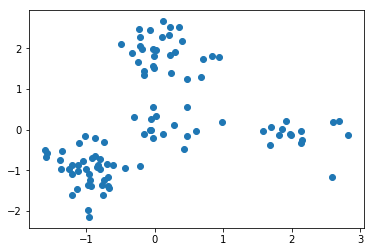

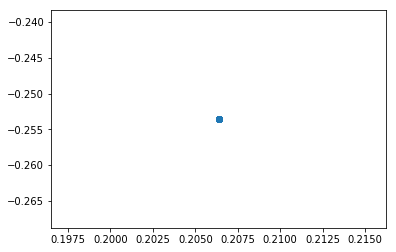

beta: 0.25
gamma: 1.0
loss=4.613802909851074, avg_feature_loss=4.169188499450684, avg_latent_loss=0.08892286568880081, avg_quantized_loss=0.35569146275520325
running batch 0 in epoch 0
k=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


embeds=[[ 0.10615754  0.0034986   0.13076437]
 [-0.17019729 -0.10511982  0.06265448]
 [-0.06191644  0.03503079 -0.08328107]
 [ 0.00125871 -0.09339564 -0.11070217]]


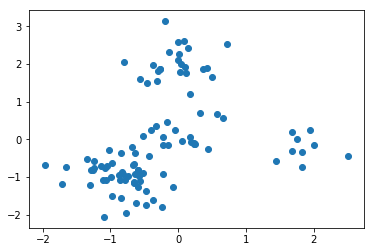

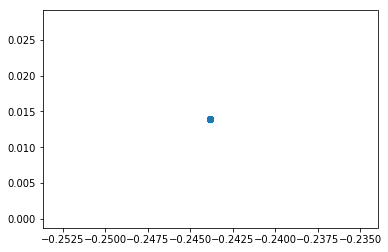

beta: 0.25
gamma: 0.28648887966174863
loss=3.6757724285125732, avg_feature_loss=3.6757726669311523, avg_latent_loss=1.2686848904763792e-08, avg_quantized_loss=5.074739561905517e-08
running batch 5625 in epoch 0
k=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
embeds=[[ 0.33067489  0.34075996  0.34529617]
 [-0.17019729 -0.10511982  0.06265448]
 [-0.06191644  0.03503079 -0.08328107]
 [ 0.00125871 -0.09339564 -0.11070217]]


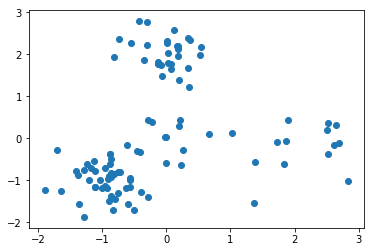

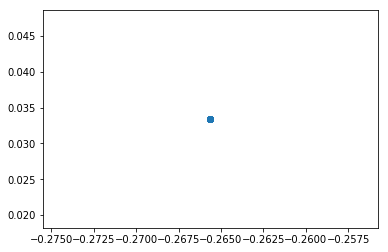

beta: 0.25
gamma: 0.0820758781698439
loss=4.203732490539551, avg_feature_loss=4.203711032867432, avg_latent_loss=4.443561920197681e-06, avg_quantized_loss=1.7774247680790722e-05
running batch 11250 in epoch 0
k=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
embeds=[[ 0.35563537  0.37502909  0.35814342]
 [-0.17019729 -0.10511982  0.06265448]
 [-0.06191644  0.03503079 -0.08328107]
 [ 0.00125871 -0.09339564 -0.11070217]]


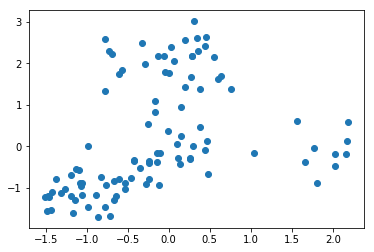

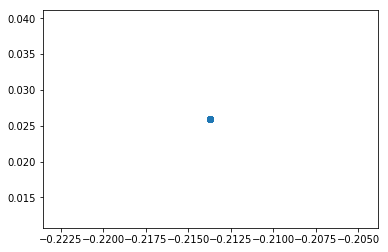

beta: 0.25
gamma: 0.023513826384132748
loss=4.101288318634033, avg_feature_loss=4.101288795471191, avg_latent_loss=5.482982512461376e-09, avg_quantized_loss=2.1931930049845505e-08
running batch 16875 in epoch 0
k=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
embeds=[[ 0.35387653  0.366207    0.35391375]
 [-0.17019729 -0.10511982  0.06265448]
 [-0.06191644  0.03503079 -0.08328107]
 [ 0.00125871 -0.09339564 -0.11070217]]


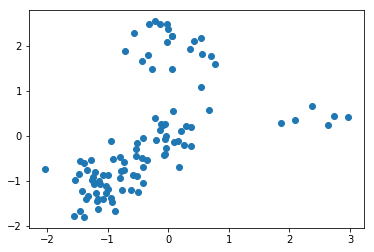

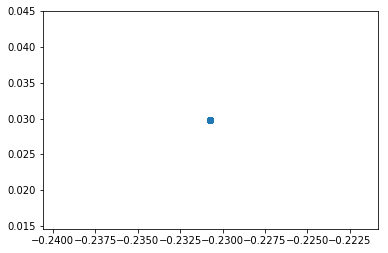

beta: 0.25
gamma: 0
loss=4.280515193939209, avg_feature_loss=4.2804179191589355, avg_latent_loss=1.945588883245364e-05, avg_quantized_loss=7.782355532981455e-05
running batch 22499 in epoch 0
k=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
embeds=[[ 0.33128721  0.34582663  0.32628965]
 [-0.17019729 -0.10511982  0.06265448]
 [-0.06191644  0.03503079 -0.08328107]
 [ 0.00125871 -0.09339564 -0.11070217]]


AttributeError: 'Tensor' object has no attribute 'kernel'

In [126]:
trainer = VectorQuantizationVAE(n_input_units=3, n_hidden_layers=2, n_hidden_units=3, n_latent_units=4, 
                                learning_rate=0.05, batch_size=100, max_beta=0.25, min_beta=0.25)
trainer.train(data, visualize=True, epochs=1)

In [8]:
feed_dict = {trainer.x: batch, trainer.beta: np.array([[beta]])}
sess.run(optimizer, feed_dict=feed_dict)

In [15]:
# self.z_e = inputs
# self.norm = tf.norm(tf.expand_dims(self.z_e, axis=-2) - self.embeds, axis=-1)
# self.k = tf.argmin(self.norm, axis=-1) # -> [latent_h,latent_w]
# self.z_q = tf.gather(self.embeds, self.k)
feed_dict = {trainer.x: batch, trainer.beta: np.array([[beta]])}
sess.run([trainer.z_q], feed_dict=feed_dict)[0].shape

(100, 9)

(array([  9.90000000e+01,   1.37000000e+03,   1.12730000e+04,
          1.14196000e+05,   1.14187000e+05,   7.66040000e+04,
          5.16410000e+04,   3.64460000e+04,   2.60790000e+04,
          1.88520000e+04,   1.36100000e+04,   1.00560000e+04,
          7.34400000e+03,   5.29900000e+03,   3.70300000e+03,
          2.68100000e+03,   1.85200000e+03,   1.40500000e+03,
          9.85000000e+02,   7.22000000e+02,   5.06000000e+02,
          3.41000000e+02,   2.54000000e+02,   1.68000000e+02,
          1.23000000e+02,   9.00000000e+01,   8.90000000e+01,
          9.30000000e+01,   1.36000000e+02,   2.03000000e+02,
          3.30000000e+02,   5.87000000e+02,   1.10600000e+03,
          2.60600000e+03,   8.22900000e+03,   1.64695000e+05,
          6.56060000e+04,   4.34900000e+03,   1.26800000e+03,
          6.03000000e+02,   3.19000000e+02,   2.57000000e+02,
          2.31000000e+02,   2.27000000e+02,   2.83000000e+02,
          3.09000000e+02,   4.03000000e+02,   5.34000000e+02,
        

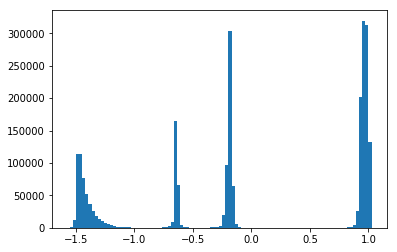

In [12]:
plt.hist(model.encoder.encode(data)[0], bins=100)

In [23]:
from sklearn.mixture import GaussianMixture



In [33]:
mus = model.encoder.encode(data)[0]

results = []

for i in range(1,10):
    m = GaussianMixture(i).fit(mus)
    results.append((i, m.score(mus), m.aic(mus), m.bic(mus)))

In [31]:
results

[(1, -1.349808787495403, 6074143.5437293136, 6074168.796610862),
 (2, -0.16352232973647432, 735860.4838141345, 735923.61601800541),
 (3, 0.2106959228959403, -948115.65303173137, -948014.6415055379),
 (4, 0.63413533432107461, -2853587.0044448357, -2853448.1135963197),
 (5, 0.65035754820199487, -2926580.9669089769, -2926404.1967381383),
 (6, 0.86345505427588054, -3885513.7442414626, -3885299.0947483014),
 (7, 0.79605181388766111, -3582193.162494475, -3581940.6336789913),
 (8, 0.8646548225404691, -3890900.7014321107, -3890610.2932943045),
 (9, 0.88927691745299919, -4001694.1285384963, -4001365.8410783675)]

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-1.5826096 , -1.52876103, -1.47491246, -1.42106389, -1.36721532,
        -1.31336675, -1.25951818, -1.20566961, -1.15182104, -1.09797247,
        -1.0441239 , -0.99027533, -0.93642676, -0.88257819, -0.82872962,
        -0.77488105, -0.72103248, -0.66718391, -0.61333534, -0.55948677,
        -0.5056382 , -0.45178963, -0.39794106, -0.34409249, -0.29024392,
        -0.23639535, -0.18254678, -0.12869821, -0.07484964, -0.02100107,
         0.0328475 ,  0.08669607,  0.14054464,  0.19439321,  0.24824178,
         0.30209035,  0.35593892,  0.40978749,  0.46363606,  0.51748463,
         0.5713332 ,  0.62518177,  0.67903034,  0.73287891,  0.78672748,
         0.84057605,  0.89442462,  0.94827319,  1.0021217

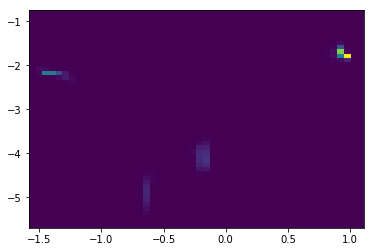

In [22]:
plt.hist2d(model.encoder.encode(data)[0].squeeze(1), model.encoder.encode(data)[1].squeeze(1), bins=50)